In [26]:
import numpy as np

import matplotlib.pyplot as plt
from matplotlib import animation
from matplotlib.animation import PillowWriter
from mpl_toolkits.mplot3d import Axes3D

from scipy.sparse.linalg import eigs, eigsh
from scipy import sparse

import torch
from torch import lobpcg

import plotly.graph_objs as go

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [27]:
N = 150

X, Y = np.meshgrid(np.linspace(0,1,N), np.linspace(0,1,N))

In [28]:
def get_potential(x, y):
    return ((x-0.5)**2 + (y-0.5)**2)*1e-2

V = np.vectorize(get_potential)(X,Y)

In [29]:
fig = go.Figure(data=[go.Surface(x=X, y=Y, z=V)])
fig.update_layout(autosize=False,
                    width = 400, height = 400)
fig.show()

In [30]:
diag = np.ones([N])
diags = np.array([diag, -2*diag, diag])

D = sparse.spdiags(diags, np.array([-1,0,1]), N, N)

T = -1/2 * sparse.kronsum(D,D)

U = sparse.diags(V.reshape(N**2), (0))

H = T + U

In [31]:
H = H.tocoo()
H = torch.sparse_coo_tensor(indices = torch.tensor(np.array([H.row, H.col])), values = torch.tensor(H.data), size = H.shape).to(device)

In [32]:
eigenvalues, eigenvectors = lobpcg(H, k=10, largest=False)

In [33]:
def get_e(n):
    return eigenvectors.T[n].reshape(N,N).cpu()

In [34]:
fig = go.Figure(data=[go.Surface(x=X, y=Y, z=get_e(3)**2)])
fig.update_layout(autosize=False,
                    width = 800, height = 800)
fig.show()

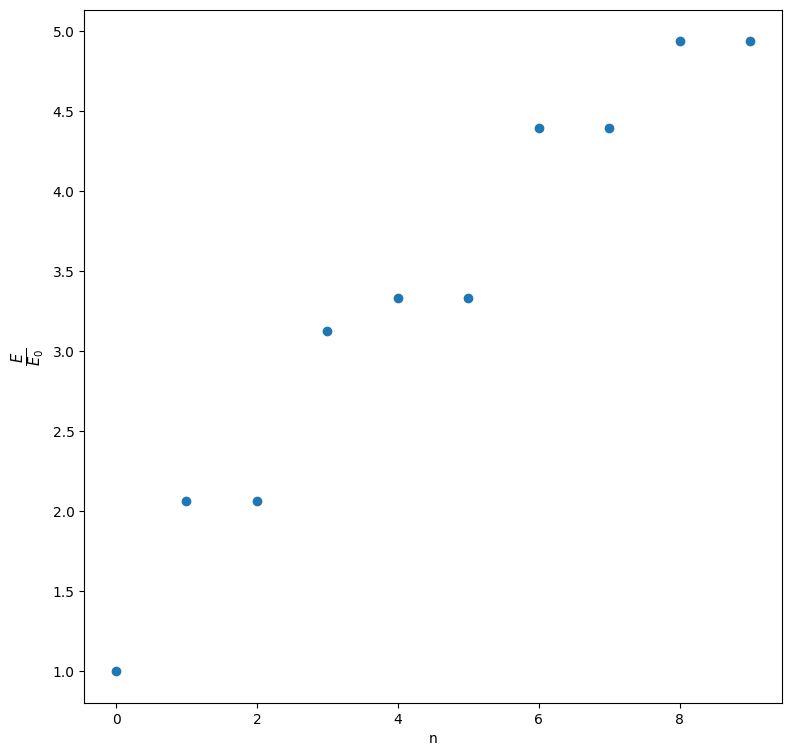

In [35]:
k = np.linspace(0, len(eigenvalues)-1, len(eigenvalues))

fig, ax = plt.subplots(figsize=(9,9))

ax.scatter(k, eigenvalues.cpu()/eigenvalues.cpu()[0])
ax.set_xlabel('n')
ax.set_ylabel(r'$\frac{E}{E_0}$', fontsize=15)

plt.show()

In [36]:
t = np.linspace(0, 2*np.pi/eigenvalues.cpu()[0], 120)


In [37]:
# fig = plt.figure()
# ax1 = fig.add_subplot(111, projection = '3d')
# ax1.set_zlim([-0.004,0.004])

# line = [ax1.plot_surface(X,Y, get_e(0)*np.exp(-1j * eigenvalues.cpu()[0] * t[0]).real, cmap='cool', linewidth=0, antialiased=False)]

# pbar = tqdm(range(122), desc='Animating...', leave=False)
# def animate(i):

#     line[0].remove()
#     line[0] = ax1.plot_surface(X,Y, get_e(0)*np.exp(-1j * eigenvalues.cpu()[0] * t[i]).real, cmap='cool', linewidth=0, antialiased=False)
#     pbar.update()
#     return fig

# anim = animation.FuncAnimation(fig, animate, frames=len(t), interval=50)

# anim.save('2D_infinite.gif', writer='pillow', fps=30, dpi=200)
# plt.show()